In [28]:
## Standard imports
import numpy as np
import matplotlib.pyplot as plt
import skimage.io, scipy.ndimage, scipy.interpolate, scipy.signal, scipy.io.wavfile
import skimage.morphology, skimage.transform, skimage.feature, scipy.stats

%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (18.0, 10.0)

#standard utilities
def show_image(img, title="untitled", cmap="gray", **kwargs):
    plt.figure()
    plt.imshow(img, cmap=cmap, interpolation="nearest", **kwargs)
    plt.axis("off")
    plt.title(title)
    
def apply_color(img, fn):
    return np.dstack((fn(img[:,:,0]),fn(img[:,:,1]),fn(img[:,:,2])))

def load_and_normalise(fname):
    return skimage.io.imread(fname) / 256.0

def load_gray(f):
    return skimage.color.rgb2gray(load_and_normalise(f))

In [32]:
# resize images
# read images into arrays
# read resized images back into folder for future use

import matplotlib.pyplot as plt
%matplotlib inline

import os
import numpy as np
from skimage.io import imread
from skimage.transform import rescale, resize, downscale_local_mean
from PIL import Image

folder = '/Users/Leonore/Documents/Workspace/l4proj/data/raw'

filenames = [os.path.join(folder, f)for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

image_width = 128
image_height = 128

dataset = np.ndarray(shape=(len(filenames), image_width, image_height), dtype=np.float32)

i = 0
for file in filenames:
    try:
        image = imread(file)
        image_resized = resize(image, (image_width, image_height), anti_aliasing=False)
        dataset[i] = image_resized
    except Exception as e:
        print(e)
        print("{} is causing issues".format(file))
    i += 1

Could not find a format to read the specified file in mode 'i'
/Users/Leonore/Documents/Workspace/l4proj/data/raw/.DS_Store is causing issues


In [33]:
from sklearn.model_selection import train_test_split

# splitting and discarding labels as we don't need them
x_train, x_test, _, _ = train_test_split(dataset, dataset, test_size=0.2, random_state=11)

In [34]:
x_train = np.reshape(x_train, (len(x_train), image_width, image_height, 1))
x_test = np.reshape(x_test, (len(x_test), image_width, image_height, 1))

In [35]:
x_train.shape

(471, 128, 128, 1)

In [36]:
# build autoencoder for dataset

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(image_width, image_height, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(8, (5, 5), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
filter_copy = x
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (5, 5), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

In [37]:
autoencoder = Model(input_img, decoded)
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 128, 128, 8)       208       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 8)         584       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 16)        1168      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 16)        0   

In [38]:
encoder = Model(inputs=input_img, outputs=encoded)
encoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 128, 128, 8)       208       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 8)         584       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 16)        1168      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 16)        0   

In [39]:
filter_copy = Model(inputs=input_img, outputs=filter_copy)
filter_copy.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 128, 128, 8)       208       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 8)         584       
Total params: 792
Trainable params: 792
Non-trainable params: 0
_________________________________________________________________


In [11]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [12]:
encoded_imgs = encoder.predict(x_train)

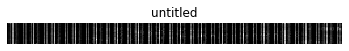

In [13]:
show_image(np.reshape(encoded_imgs[0],(encoder.output.shape[1], encoder.output.shape[2]*encoder.output.shape[3])))

In [14]:
# input = output because this is image reconstruction
autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True)

Epoch 1/50
471/471 [==============================] - 7s 15ms/step - loss: 0.6918
Epoch 2/50
471/471 [==============================] - 7s 14ms/step - loss: 0.6833
Epoch 3/50
471/471 [==============================] - 7s 14ms/step - loss: 0.6640
Epoch 4/50
471/471 [==============================] - 7s 15ms/step - loss: 0.6031
Epoch 5/50
471/471 [==============================] - 6s 14ms/step - loss: 0.3799
Epoch 6/50
471/471 [==============================] - 7s 15ms/step - loss: 0.0767
Epoch 7/50
471/471 [==============================] - 6s 13ms/step - loss: 0.0418
Epoch 8/50
471/471 [==============================] - 6s 13ms/step - loss: 0.0395
Epoch 9/50
471/471 [==============================] - 6s 12ms/step - loss: 0.0390
Epoch 10/50
471/471 [==============================] - 6s 12ms/step - loss: 0.0388
Epoch 11/50
471/471 [==============================] - 6s 13ms/step - loss: 0.0387
Epoch 12/50
471/471 [==============================] - 6s 14ms/step - loss: 0.0386
Epoch 13/50
4

In [18]:
decoded_imgs = autoencoder.predict(x_train)

In [25]:
np.amax(x_train)

0.062485695

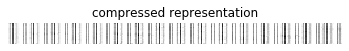

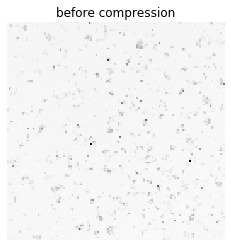

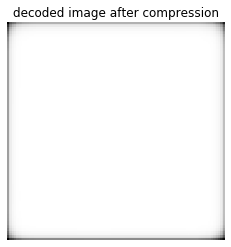

In [19]:
d1 = np.reshape(decoded_imgs[2], (image_width, image_height))
show_image(np.reshape(encoded_imgs[2],(encoder.output.shape[1], encoder.output.shape[2]*encoder.output.shape[3])), "compressed representation", cmap="gist_yarg")
e1 = np.reshape(x_train[2], (image_width, image_height))
show_image(e1, 'before compression', cmap='gist_yarg')
show_image(d1, 'decoded image after compression', cmap='gist_yarg')